# Exploring the Datasets
*Authors: Angelika Shastapalava, Excel Espina, David Hadaller, Sam Mundle*  

### What data we are using:  
1) The "Discovery" API is MTA's official developer resource to get real-time data from their NYC Bus Time service. You can get more information <a href="http://bustime.mta.info/wiki/Developers/Index">here</a>  
2) Kaggle's NYC Bus Data <a href="https://www.kaggle.com/stoney71/new-york-city-transport-statistics">here</a>

### Goals, or how are we using the data:
Our plan is to explore the following:  
> 1. Predicting the probaility, given that a passenger approaches a bus stop within at a particular time interval during the day, that a bus will be late.
>2. What environmental factors impact a buses schedule? What impact does time of day,
temperature, and weather have?
> 3. Based on a ~10 stops/lines how closely do the actual stop times reflect the posted bus
schedules and what is the distribution around the scheduled time that busses actually
arrive?


### Sections:
1) [Background Information](#Background-Information) 

2) [Loading the Datasets](#Loading-the-Datasets) 

3) [Cleaning the Data](#Cleaning-the-Data)  

4) [Visualizing the Data](#Visualizing-the-Data)

## Background Information

#### Background Reading for Goal 1
Doing some background reading, we came across two articles, one [by Jake Vanderplas](http://jakevdp.github.io/blog/2018/09/13/waiting-time-paradox/), developer of data science tools and director open software at the University of Washington's eScience Institute, and another [by Allen Downey](http://allendowney.blogspot.com/2015/08/the-inspection-paradox-is-everywhere.html), a Professor of Computer Science at Olin College and author of many data science texts. Both of their articles coincide with our research goals, but since they're similar, we'll focus mainly Allen Downey's work.  

In his article, Downey discusses the inspection paradox as applied to many different data sets, including train arrival times. What follows is a brief summary of the inspection paradox, which explains why most people can truthfully report that trains are overcrowded and late, despite the train operator's equally truthful observation that *most* trains aren't drastically late or crowded. Say that the mean wait time between busses is 10 minutes. Also assume that if train B is late, train A cannot step in to serve those waiting customers even if it's closer. So then, given that late trains, by definition, arrive after a long wait interval, then if we're choosing a random time to approach the patform, there's more of a chance that the train we board will be a late train. This is especially true if the time interval between trains features a high variance. Based on the scenario described, the waiting time paradox also makes the claim that ,when the average time between arrivals is $n$, customers experience an average wait interval experienced of $2n$.

Allen Downey tests this claim this by plotting the actual distribution of time between trains on the Red Line in Boston, and the biased distribution that would be observed by passengers of that line. His observations and a plot of that data are as follows:

> The average time between trains is 7.8 minutes, so we might expect the average wait time to be 3.8 minutes.  But the average of the biased distribution is 8.8 minutes, and the average wait time for passengers is 4.4 minutes, about 15% longer.
> 
> In this case the difference between the two distributions is not very big because the variance of the actual distribution is moderate.  When the actual distribution is long-tailed, the effect of the inspection paradox can be much bigger.


<img src="images/1-time-between-trains.png" alt="drawing" width="600"/>

Of course, as he explains in the above quote, Downey does not find the same trend as the idealized inspecition paradox--when the average time between arrivals is $n$, customers experience an average wait interval experienced of $2n$. Certainly, small variance he cites This is a likely reason for these observations, however, it's can also be true that passengers do not approach the train platform at a *uniformly* random time. Mass transit usage likely features some other kind of distribution (perhaps a bimodal distibution, since people commute to work in the morning and then back home in the evening.) 

For our purposes, creating a biased distribution to test whether the MTA bus data can be described by the inspection paradox would require two things:
1. Bus times deltas: that is, the intervals between different bus arrival times at a given stop. We need this to compute the actual ecdf (shown in dark blue.) 
2. Passenger Data: we need to know how many passengers boarded each bus that stopped at the particular stop in question. This data would be used to create the light blue, biased ecdf, which describes probability from the passenger's perspective.

This biased distribution would help us guage probability from the customer standpoint. We're not pointing at busses as they leave the station, assessing the probability as to whether they'll be late. Instead, we're guaging the probability that a customer, who makes his/her way to a stop, will board a late bus.

Once we have this biased distribution, we can find the impact of conditional probabilities due to various weather events (taken from external data) on average user wait time (the biased chart.) This leads us into goal 2.

### Our Data Analysis
The goal of our data analysis is to build on what Downey's work, only with the MTA bus times. We aim to find the distribution of time intervals between one bus leaving and the next bus coming (we call these "time deltas"). If these time intervals feature a great deal of variance, many passengers will experience the inspection paradox; i.e. if they approach a bus stop at a uniform, random time, even if the average (mean) bus arrives on time, most passengers will experience long wait times. 

After we've created an ecdf of the time deltas, we can later simulate the probability that a given passenger will experience a delay using montecarlo methods and/or add conditional probabilities to our analysis with weather data. We must simulate passenger behavior with montecarlo methods because, unlike the Red Line in Boston, the MTA only publishes ridership data as a year-end sum, not for individual bus rides.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime, math, glob

### Loading the Datasets 
We want to work with the Kaggle dataset so head over <a href="https://www.kaggle.com/stoney71/new-york-city-transport-statistics">here</a> and download the zip file. (A word of caution: the dataset is approx **5GB** when extracted!)

After you extract the data, we want to load a csv on our notebook.  

The `error_bad_lines=False` parameter fixes some formatting issues when we load in our dataset.

In [2]:
# %%capture
# df = pd.concat([pd.read_csv(f, error_bad_lines=False) for f in glob.glob('origData/mta*.csv')], ignore_index = True)

Use the next cell only for 1 month analysis.

In [3]:
%%capture
f = "origData/mta_1708.csv"
df = pd.read_csv(f, error_bad_lines=False)

In [4]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-08-01 00:01:03,0,Q32,W 32 ST/7 AV,40.749405,-73.991020,JACKSON HTS NORTHERN - 81 via ROOSVLT,40.755322,-73.886139,NYCT_7424,40.749403,-73.990841,W 32 ST/AV OF THE AMERICAS,< 1 stop away,220.0,2017-08-01 00:01:37,24:01:11
1,2017-08-01 00:00:52,0,B35,39 ST/1 AV,40.656456,-74.012245,BROWNSVILLE M GASTON BL via CHURCH,40.656345,-73.907188,NYCT_406,40.651330,-73.938960,CHURCH AV/E 42 ST,approaching,107.0,2017-08-01 00:02:00,23:56:12
2,2017-08-01 00:01:18,1,Q83,227 ST/113 DR,40.702263,-73.730339,JAMAICA HILLSIDE - 153 via LIBERTY,40.706795,-73.804100,NYCT_6449,40.706532,-73.804177,153 ST/HILLSIDE AV,at stop,25.0,2017-08-01 00:01:27,24:00:00
3,2017-08-01 00:01:05,0,M60-SBS,BROADWAY/W 106 ST,40.801819,-73.967644,SELECT BUS SERVICE LA GUARDIA AIRPORT,40.768074,-73.862091,NYCT_5846,40.770403,-73.917687,HOYT AV/31 ST,4.1 miles away,6519.0,2017-08-01 00:06:47,23:39:14
4,2017-08-01 00:01:05,0,M60-SBS,BROADWAY/W 106 ST,40.801819,-73.967644,SELECT BUS SERVICE LA GUARDIA AIRPORT,40.768074,-73.862091,NYCT_5846,40.770403,-73.917687,HOYT AV/31 ST,4.1 miles away,6519.0,2017-08-01 00:06:47,23:44:32


## Cleaning the Data
For this EDA, we're only going to be looking at the **M100** bus with the route going to **Inwood 220 St Via Amsterdam Via Bway**. We are interested in the stop data in **W 125 St/St Nicholas Av**

In [5]:
df_m100 = df.loc[(df['PublishedLineName']== 'M100') & (df['DestinationName'] == 'INWOOD 220 ST via AMSTERDAM via BWAY'),]


We want to look at M100 buses that have reported ```at stop``` on ```ArrivalProximityText``` whose ```OriginName``` is the stop before **W 125 St/St Nicholas Av**, ```W 125 ST/FRED DOUGLASS BL```

In [6]:
# M100_FD = m100.loc[(m100['ArrivalProximityText'] == 'at stop') & (m100['NextStopPointName'] == 'W 125 ST/FRED DOUGLASS BL'),]
df_nick_m100 = df_m100.loc[(df_m100['ArrivalProximityText'] == 'at stop') & (df_m100['NextStopPointName'] == 'W 125 ST/ST NICHOLAS AV'),]


In [7]:
df_nick_m100.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
43022,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,40.810861,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:49:06
43023,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,40.810861,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:50:48
43024,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,40.810861,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:51:39
90460,2017-08-01 11:02:25,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8384,40.810907,-73.952928,W 125 ST/ST NICHOLAS AV,at stop,11.0,2017-08-01 11:02:42,11:04:39
124608,2017-08-01 13:42:23,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8391,40.810881,-73.952865,W 125 ST/ST NICHOLAS AV,at stop,17.0,2017-08-01 13:43:07,13:35:20


Here we're cleaning the dataset, specifically in the "ExpectedArrivalTime" and "ScheduledArrivalTime".

This is a pretty crude cleaning technique since we lose a lot of (*valuable?*) data.

In [8]:
df_nick_m100.dropna(subset=["ExpectedArrivalTime", "ScheduledArrivalTime"], inplace=True)
df_nick_m100.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(89, 17)

Now we have a dataframe of M100 buses that have stopped at Nicholas. 

Our next step would be to compare the expected arrival to scheduled.

~~Also, how about we limit our the scope to 7 days from Aug 5 to Aug 11.~~

In [9]:
# Changing obj to datetime 
df_nick_m100['RecordedAtTime'] = pd.to_datetime(df_nick_m100['RecordedAtTime'])

# Sort the time 
df_nick_m100 = df_nick_m100.sort_index()

# M100_FD[(M100_FD['RecordedAtTime'] > '2017-08-05 05:00:00') & 
#             (M100_FD['RecordedAtTime'] < '2017-08-11 21:00:00')]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Getting the Time Deltas between Buses

First changing the object types to datetime.

In [10]:
df_nick_m100['ExpectedArrivalTime'] = pd.to_datetime(df_nick_m100['ExpectedArrivalTime'])

Then calculate the delta

In [14]:
df_nick_m100['time_diff_bus'] = df_nick_m100['ExpectedArrivalTime'].diff()

Converting to mins.

In [15]:
df_nick_m100['time_diff_bus_mins'] = df_nick_m100['time_diff_bus'].dt.total_seconds().div(60, fill_value=0).apply(math.ceil).astype(int)

In [16]:
df_nick_m100.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,time_diff_bus,time_diff_bus_mins
43022,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,40.810861,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:49:06,NaT,0
43023,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,40.810861,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:50:48,00:00:00,0
43024,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,40.810861,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:51:39,00:00:00,0
90460,2017-08-01 11:02:25,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8384,40.810907,-73.952928,W 125 ST/ST NICHOLAS AV,at stop,11.0,2017-08-01 11:02:42,11:04:39,03:10:39,191
124608,2017-08-01 13:42:23,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8391,40.810881,-73.952865,W 125 ST/ST NICHOLAS AV,at stop,17.0,2017-08-01 13:43:07,13:35:20,02:40:25,161


Now we save our progress to a CSV file.

In [17]:
df_nick_m100.to_csv('M100_Aug_W125_st.csv', encoding='utf-8', index=False)

We then import the csv as a dataframe, because my (David Hadaller) laptop cannot handle importing 'mta_1708.csv', a 1.5 GB file, as Excel did in the cells above.

In [18]:
M100_NICK = pd.read_csv('M100_Aug_W125_st.csv')

In [19]:
def ecdf(inputSeries):
    try:
        x = np.sort(inputSeries)
    except:
        print("Warning: Series Unsorted")
        x = inputSeries
    y = np.arange(1, len(x)+1) / len(x)
    _ = plt.plot(x, y, marker='.', linestyle='none')
    _ = plt.xlabel('Time Delta (minutes)')
    _ = plt.ylabel('ECDF')
    plt.margins(0.02) # Keeps data off plot edges
    plt.show()
    
def hist(inputSeries):
    plt.hist(inputSeries, bins=25, density=True)
    _ = plt.xlabel('Time Delta (minutes)')
    _ = plt.ylabel('PDF')
    plt.show()

The charts below represent the ecdf and pdf of the bus average "time deltas" or time intervals between the departure of of one bus and the arrival of the next, over the course of the month of August in 2017. Also included are some acompanying summary statistics. Notice that, apart from a single outlier, these measurements do form some sort of distribution. Parameter estimation by bootstrapping could help us validate some hypotheses. Once we have a proper theoretical distribution to model this data, we can then use montecarlo metods to simluate passenger experience. So, what we've done is to derive the actual cdf (the dark blue line in the chart on the background information section), which means generating the biased cdf (the light blue line in the same background section) remains.

In [24]:
M100_NICK_Avg = M100_NICK[['RecordedAtTime','time_diff_bus_mins']]
dates = M100_NICK_Avg['RecordedAtTime'].str.split(' ', 1, expand=True).drop([1],axis=1)
M100_NICK_Avg = pd.concat([dates,M100_NICK_Avg['time_diff_bus_mins']],axis=1).rename(columns={0:'Date','time_diff_bus_mins':'TimeDelta'})
M100_NICK_Avg = M100_NICK_Avg.groupby('Date').mean().dropna()
M100_NICK_Avg.head()

,TimeDelta
Date,
2017-08-01,59.545455
2017-08-02,731.500000
2017-08-03,697.000000
2017-08-04,551.000000
2017-08-05,716.500000


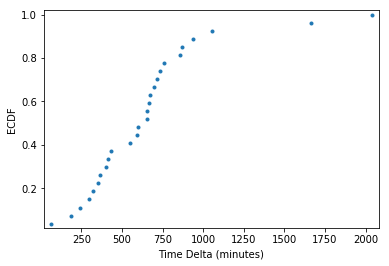

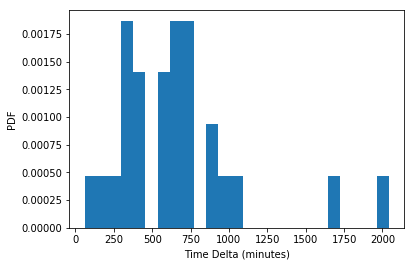

count      27.000000
mean      658.526010
std       422.039410
min        59.545455
25%       384.500000
50%       654.666667
75%       744.000000
max      2042.000000
Name: TimeDelta, dtype: float64

In [25]:
ecdf(M100_NICK_Avg['TimeDelta'])
hist(M100_NICK_Avg['TimeDelta'])
M100_NICK_Avg['TimeDelta'].describe()

Below, we have also begun to plot time delta behavior for an individual day. 

In [27]:
M100_NICK_day1 = M100_NICK[['RecordedAtTime','time_diff_bus_mins']]
dates = M100_NICK_day1['RecordedAtTime'].str.split(' ', 1, expand=True)
M100_NICK_day1 = pd.concat([dates,M100_NICK_day1['time_diff_bus_mins']],axis=1).rename(columns={0:'Date',1:'RecordingTime','time_diff_bus_mins':'TimeDelta'})
M100_NICK_day1 = M100_NICK_day1[M100_NICK_day1['Date']=='2017-08-01']
M100_NICK_day1 = M100_NICK_day1.drop_duplicates().drop(['Date'],axis=1).groupby('RecordingTime')
M100_NICK_day1.head()

,RecordingTime,TimeDelta
0,07:51:49,0
3,11:02:25,191
4,13:42:23,161
5,13:52:39,10
6,15:53:02,121
7,17:02:43,71
8,17:22:52,20
9,17:32:54,11
10,18:42:04,70


In [ ]:
#Visualizing the Time Delta for one day's trips
#day1Times = M100_NICK_day1['TimeDelta']
#day1Times.head()
#ecdf(day1Times)
#hist(day1Times)
#day1Times.describe()